In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
signal_tmp_pt = pd.read_excel("/content/drive/MyDrive/RP_A/ML_Dataset.xlsx")

Mounted at /content/drive


--- Starting ML Model Evaluation ---
Data Split: Train=5945, Test=2548
Numerical features imputed using median.
Categorical features imputed using most frequent.
Categorical features encoded into 48 columns.
Numerical features scaled.
NaNs in X_train_final before fit: 0
NaNs in X_test_final before predict: 0
Training ML Models...
ML Models Trained.
Calculating ML ROC data...
Random Forest AUC: 0.7939
Gradient Boosting AUC: 0.8958

--- Starting Traditional Method Evaluation ---
Using 8482 PTs with valid scores and labels for traditional ROC analysis.
ROR (ROR025) AUC: 0.7480
BCPNN (IC025) AUC: 0.8335

--- Plotting Combined ROC Curves ---


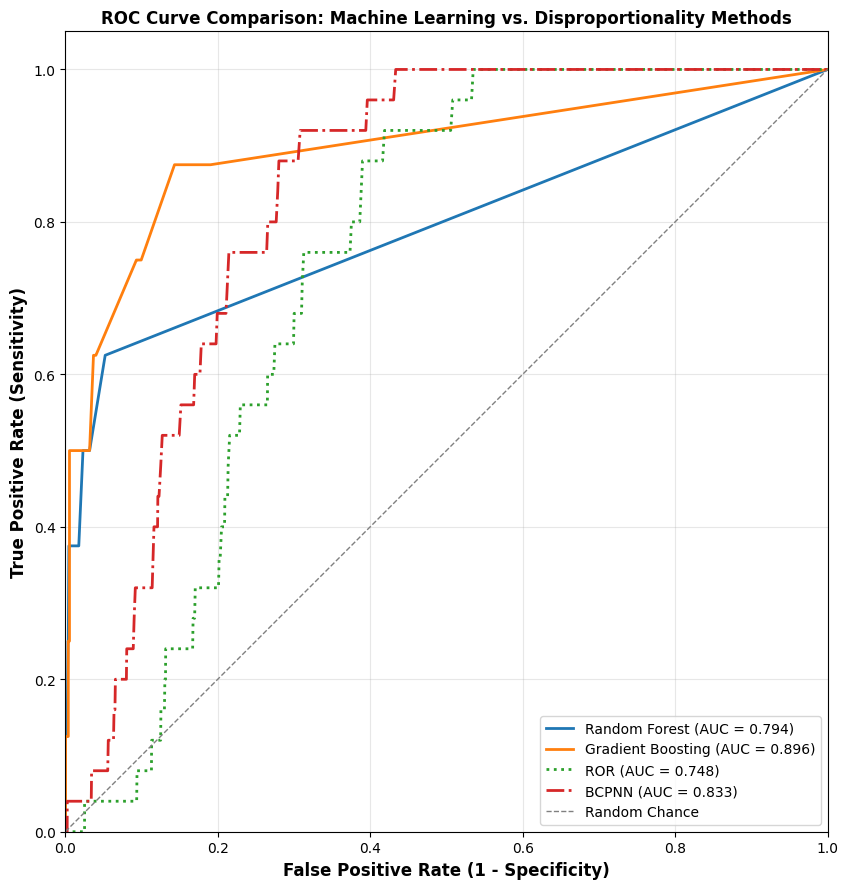

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.impute import SimpleImputer


print("--- Starting ML Model Evaluation ---")

# Dataset read
signal_tmp_pt = pd.read_excel("/content/drive/MyDrive/RP_A/ML_Dataset.xlsx")

numerical_cols = ['CASE Reports', 'a', 'b', 'c', 'd', 'ror_lower_bound', 'bcpnn_lower_bound', 'sex_ratio']
categorical_cols = ['age_group_mode', 'weight_group_mode', 'outc_cod_mode', 'soc_n']
label_col = 'y_true'


# DailyMed Labels
true_signal_pts = {
    'DEPRESSIVE SYMPTOM',
    'OBSESSIVE-COMPULSIVE DISORDER',
    'BULIMIA NERVOSA',
    'PANIC DISORDER',
    'ANOREXIA',
    'ANXIETY',
    'ASTHENIA',
    'DIARRHOEA',
    'DRY MOUTH',
    'DYSPEPSIA',
    'INFLUENZA LIKE ILLNESS',
    'INFLUENZA',
    'LIBIDO DECREASED',
    'INSOMNIA',
    'NAUSEA',
    'NERVOUSNESS',
    'NASOPHARYNGITIS',
    'RASH',
    'SINUSITIS',
    'SOMNOLENCE',
    'NIGHT SWEATS',
    'COLD SWEAT',
    'TREMOR',
    'VASODILATATION',
    'YAWNING'}

signal_tmp_pt['y_true'] = signal_tmp_pt['PT'].apply(lambda pt: 1 if pt in true_signal_pts else 0)



all_cols = numerical_cols + categorical_cols + [label_col]
if not all(col in signal_tmp_pt.columns for col in all_cols):
     raise ValueError("DataFrame missing required columns")

X_num = signal_tmp_pt[numerical_cols].copy()
X_cat = signal_tmp_pt[categorical_cols].copy()
y = signal_tmp_pt[label_col].copy()

# Split Datasets
indices = signal_tmp_pt.index
train_indices, test_indices = train_test_split(indices, test_size=0.3, random_state=42, stratify=y)

X_num_train, X_num_test = X_num.loc[train_indices], X_num.loc[test_indices]
X_cat_train, X_cat_test = X_cat.loc[train_indices], X_cat.loc[test_indices]
y_train, y_test = y.loc[train_indices], y.loc[test_indices]

print(f"Data Split: Train={len(y_train)}, Test={len(y_test)}")

# Feature Engineering

# Impute missing numerical values BEFORE scaling
# Use median strategy as it's less sensitive to outliers
num_imputer = SimpleImputer(strategy='median')
X_num_train = pd.DataFrame(num_imputer.fit_transform(X_num_train), columns=numerical_cols, index=X_num_train.index)
X_num_test = pd.DataFrame(num_imputer.transform(X_num_test), columns=numerical_cols, index=X_num_test.index)
print("Numerical features imputed using median.")

# Impute missing categorical values BEFORE encoding (use most frequent)
cat_imputer = SimpleImputer(strategy='most_frequent')
X_cat_train = pd.DataFrame(cat_imputer.fit_transform(X_cat_train), columns=categorical_cols, index=X_cat_train.index)
X_cat_test = pd.DataFrame(cat_imputer.transform(X_cat_test), columns=categorical_cols, index=X_cat_test.index)
print("Categorical features imputed using most frequent.")


# Categorical variabes: One-Hot Encoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(X_cat_train)
X_cat_train_encoded = ohe.transform(X_cat_train)
X_cat_test_encoded = ohe.transform(X_cat_test)
encoded_cat_names = ohe.get_feature_names_out(categorical_cols)
X_cat_train_df = pd.DataFrame(X_cat_train_encoded, index=X_cat_train.index, columns=encoded_cat_names)
X_cat_test_df = pd.DataFrame(X_cat_test_encoded, index=X_cat_test.index, columns=encoded_cat_names)
print(f"Categorical features encoded into {X_cat_train_df.shape[1]} columns.")

# Quantatitve variables：Scaling (StandardScaler)
scaler = StandardScaler()
scaler.fit(X_num_train) # Fit on imputed numerical training data
X_num_train_scaled = scaler.transform(X_num_train)
X_num_test_scaled = scaler.transform(X_num_test)
X_num_train_df = pd.DataFrame(X_num_train_scaled, index=X_num_train.index, columns=numerical_cols)
X_num_test_df = pd.DataFrame(X_num_test_scaled, index=X_num_test.index, columns=numerical_cols)
print("Numerical features scaled.")

# Features Concat
X_train_final = pd.concat([X_num_train_df, X_cat_train_df], axis=1)
X_test_final = pd.concat([X_num_test_df, X_cat_test_df], axis=1)


# Check for NaNs after concatenation
print(f"NaNs in X_train_final before fit: {X_train_final.isna().sum().sum()}")
print(f"NaNs in X_test_final before predict: {X_test_final.isna().sum().sum()}")


X_train_to_use = X_train_final
y_train_to_use = y_train
X_test_to_use = X_test_final
y_test_to_use = y_test


# Model Training
print("Training ML Models...")
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model = RandomForestClassifier( n_estimators=100,random_state=42, class_weight='balanced' )
# Use HistGradientBoostingClassifier which handles NaNs natively if available and imputation is not preferred
# from sklearn.ensemble import HistGradientBoostingClassifier
# gb_model = HistGradientBoostingClassifier(random_state=42)
# OR continue with standard GBM after imputation
# gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=400,
                          learning_rate=0.001,
                          subsample=0.9,
                          max_depth=3,
                          min_samples_leaf=2,
                          min_samples_split = 5)
rf_model.fit(X_train_to_use, y_train_to_use)
gb_model.fit(X_train_to_use, y_train_to_use) # Fit on imputed/cleaned data
print("ML Models Trained.")



# Model Evaluation ML & Calculate ROC/AUC
print("Calculating ML ROC data...")
try:
    # Predict on potentially cleaned test data
    rf_probs = rf_model.predict_proba(X_test_to_use)[:, 1]
    gb_probs = gb_model.predict_proba(X_test_to_use)[:, 1]

    # Evaluate against corresponding test labels
    fpr_rf, tpr_rf, _ = roc_curve(y_test_to_use, rf_probs)
    auc_rf = auc(fpr_rf, tpr_rf)
    print(f"Random Forest AUC: {auc_rf:.4f}")

    fpr_gb, tpr_gb, _ = roc_curve(y_test_to_use, gb_probs)
    auc_gb = auc(fpr_gb, tpr_gb)
    print(f"Gradient Boosting AUC: {auc_gb:.4f}")
except ValueError as e:
     print(f"ValueError during ROC calculation: {e}. Check if y_test_to_use has both classes after potential dropping.")
     # Handle error, maybe print shapes and value counts
     print("X_test_to_use shape:", X_test_to_use.shape)
     print("y_test_to_use value counts:", y_test_to_use.value_counts())

     fpr_rf, tpr_rf, auc_rf = None, None, None
     fpr_gb, tpr_gb, auc_gb = None, None, None
except Exception as e:
    print(f"Error calculating ML ROC: {e}")
    fpr_rf, tpr_rf, auc_rf = None, None, None
    fpr_gb, tpr_gb, auc_gb = None, None, None


# Disproportionality Analysis Method Evaluation

print("\n--- Starting Traditional Method Evaluation ---")




# Validate and Prepare Traditional Data

required_trad_cols = ['PT', 'ror_lower_bound', 'bcpnn_lower_bound', 'y_true']
if not all(col in signal_tmp_pt.columns for col in required_trad_cols):
    raise ValueError(f"DataFrame 'signal_tmp_pt' is missing required columns: {required_trad_cols}")

roc_data_trad = signal_tmp_pt[required_trad_cols].copy()
roc_data_trad['ror_lower_bound'] = pd.to_numeric(roc_data_trad['ror_lower_bound'], errors='coerce')
roc_data_trad['bcpnn_lower_bound'] = pd.to_numeric(roc_data_trad['bcpnn_lower_bound'], errors='coerce')
roc_data_trad['y_true'] = pd.to_numeric(roc_data_trad['y_true'], errors='coerce').fillna(-1).astype(int)

roc_data_trad.dropna(subset=['ror_lower_bound', 'bcpnn_lower_bound'], inplace=True)
roc_data_trad = roc_data_trad[roc_data_trad['y_true'].isin([0, 1])]
print(f"Using {len(roc_data_trad)} PTs with valid scores and labels for traditional ROC analysis.")


# Calculate ROC/AUC for Traditional methods
auc_ror, fpr_ror, tpr_ror = None, None, None
auc_bcpnn, fpr_bcpnn, tpr_bcpnn = None, None, None

if not roc_data_trad.empty and len(np.unique(roc_data_trad['y_true'])) >= 2:
    y_true_trad = roc_data_trad['y_true']

    # ROR
    y_score_ror = roc_data_trad['ror_lower_bound']
    if not y_score_ror.isnull().all():
        try:
            fpr_ror, tpr_ror, _ = roc_curve(y_true_trad, y_score_ror)
            auc_ror = auc(fpr_ror, tpr_ror)
            print(f"ROR (ROR025) AUC: {auc_ror:.4f}")
        except ValueError as e: print(f"Could not calculate ROC for ROR: {e}")

    # BCPNN
    y_score_bcpnn = roc_data_trad['bcpnn_lower_bound']
    if not y_score_bcpnn.isnull().all():
         try:
            fpr_bcpnn, tpr_bcpnn, _ = roc_curve(y_true_trad, y_score_bcpnn)
            auc_bcpnn = auc(fpr_bcpnn, tpr_bcpnn)
            print(f"BCPNN (IC025) AUC: {auc_bcpnn:.4f}")
         except ValueError as e: print(f"Could not calculate ROC for BCPNN: {e}")
else:
    print("Not enough data or only one class present for traditional methods ROC.")



# Combined Plotting

print("\n--- Plotting Combined ROC Curves ---")
fig, ax = plt.subplots(figsize=(10, 9))

# Plot ML Models
if auc_rf is not None:
    ax.plot(fpr_rf, tpr_rf,lw=2, label=f'Random Forest (AUC = {auc_rf:.3f})')

if auc_gb is not None:
    ax.plot(fpr_gb, tpr_gb,lw=2, label=f'Gradient Boosting (AUC = {auc_gb:.3f})')

# Plot Traditional Methods
if auc_ror is not None:
    ax.plot(fpr_ror, tpr_ror,lw=2, linestyle=':',label=f'ROR (AUC = {auc_ror:.3f})')

if auc_bcpnn is not None:
    ax.plot(fpr_bcpnn, tpr_bcpnn,lw=2, linestyle='-.',label=f'BCPNN (AUC = {auc_bcpnn:.3f})')

# Only draw the chance line if at least one curve is present
if any(auc is not None for auc in [auc_rf, auc_gb, auc_ror, auc_bcpnn]):
    ax.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=1,label='Random Chance')

# Formatting
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.05)
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontweight='bold', fontsize=12)
ax.set_ylabel('True Positive Rate (Sensitivity)',  fontweight='bold', fontsize=12)
ax.set_title('ROC Curve Comparison: Machine Learning vs. Disproportionality Methods', fontsize=12, fontweight='bold')
ax.legend(loc="lower right", frameon=True)
ax.grid(alpha=0.3)
ax.set_aspect('equal', 'box')

fig.tight_layout()
fig.savefig("/content/drive/My Drive/RP_A/REPORT/VISUALIZATIONS/Model_Performance_Plot.png", dpi=300, bbox_inches='tight')


In [ ]:
# Analyze Feature Importance
feature_importances = gb_model.feature_importances_
feature_names = X_train_to_use.columns

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.head(20)



,Feature,Importance
2,b,0.225243
0,CASE Reports,0.130784
1,a,0.118855
19,weight_group_mode_60-75 kg,0.111044
6,bcpnn_lower_bound,0.089175
5,ror_lower_bound,0.083487
7,sex_ratio,0.065176
35,soc_n_Gastrointestinal disorders,0.057957
4,d,0.021610
3,c,0.018949


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("\n--- Generating Performance Metrics Table ---")

performance_data = []

# Machine Learning Models Metrics

# Function to find optimal threshold using Youden's J
def find_optimal_threshold(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    j_scores = tpr - fpr # Youden's J statistic
    ix = np.argmax(j_scores)
    optimal_thresh = thresholds[ix]
    # Ensure threshold is not inf/-inf if it occurs at ends
    if optimal_thresh == np.inf:
         optimal_thresh = thresholds[thresholds != np.inf].max()
    elif optimal_thresh == -np.inf:
         optimal_thresh = thresholds[thresholds != -np.inf].min()

    # Sensitivity and specificity at this threshold
    sensitivity = tpr[ix]
    specificity = 1.0 - fpr[ix]
    return optimal_thresh, sensitivity, specificity


# Random Forest
if auc_rf is not None:
    print("Calculating RF optimal threshold...")
    try:
        rf_thresh, rf_sens, rf_spec = find_optimal_threshold(y_test, rf_probs)
        performance_data.append({
            'Method': 'Random Forest',
            'Threshold': f'Prob ≥ {rf_thresh:.2f}', # Found optimal threshold
            'AUROC': f"{auc_rf:.3f}",
            'Sensitivity': f"{rf_sens:.1%}",
            'Specificity': f"{rf_spec:.1%}"})
    except Exception as e:
        print(f"Error calculating RF metrics: {e}")
        performance_data.append({'Method': 'Random Forest', 'AUROC': f"{auc_rf:.3f}", 'Threshold': 'N/A', 'Sensitivity': 'N/A', 'Specificity': 'N/A'})


# Gradient Boosting
if auc_gb is not None:
    print("Calculating GB optimal threshold...")
    try:
        gb_thresh, gb_sens, gb_spec = find_optimal_threshold(y_test, gb_probs)
        performance_data.append({
            'Method': 'Gradient Boosting',
            'Threshold': f'Prob ≥ {gb_thresh:.2f}',
            'AUROC': f"{auc_gb:.3f}",
            'Sensitivity': f"{gb_sens:.1%}",
            'Specificity': f"{gb_spec:.1%}"})
    except Exception as e:
        print(f"Error calculating GB metrics: {e}")
        performance_data.append({'Method': 'Gradient Boosting', 'AUROC': f"{auc_gb:.3f}", 'Threshold': 'N/A', 'Sensitivity': 'N/A', 'Specificity': 'N/A'})


# Disproportionality Analysis Metrics

# Function to calculate sens/spec at a FIXED threshold
def calculate_metrics_at_threshold(y_true, y_score, threshold):
    if y_score is None or y_true is None or len(y_true) == 0:
        return 'N/A', 'N/A'
    try:
        # Apply threshold to get binary predictions
        y_pred_binary = (y_score > threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        return sensitivity, specificity
    except Exception as e:
        print(f"Error calculating confusion matrix metrics: {e}")
        return 'N/A', 'N/A'


# ROR (using ROR025 > 1)
if auc_ror is not None:
    print("Calculating ROR metrics at Threshold > 1...")
    y_true_trad = roc_data_trad['y_true']
    y_score_ror = roc_data_trad['ror_lower_bound']
    ror_sens, ror_spec = calculate_metrics_at_threshold(y_true_trad, y_score_ror, threshold=1)
    performance_data.append({
        'Method': 'ROR (ROR025)',
        'Threshold': '> 1',
        'AUROC': f"{auc_ror:.3f}",
        'Sensitivity': f"{ror_sens:.1%}" if isinstance(ror_sens, (int, float)) else ror_sens,
        'Specificity': f"{ror_spec:.1%}" if isinstance(ror_spec, (int, float)) else ror_spec})


# BCPNN (using IC025 > 1)
if auc_bcpnn is not None:
    print("Calculating BCPNN metrics at Threshold > 1...")
    y_true_trad = roc_data_trad['y_true']
    y_score_bcpnn = roc_data_trad['bcpnn_lower_bound']
    bcpnn_sens, bcpnn_spec = calculate_metrics_at_threshold(y_true_trad, y_score_bcpnn, threshold=1)
    performance_data.append({
        'Method': 'BCPNN (IC025)',
        'Threshold': '> 1',
        'AUROC': f"{auc_bcpnn:.3f}",
        'Sensitivity': f"{bcpnn_sens:.1%}" if isinstance(bcpnn_sens, (int, float)) else bcpnn_sens,
        'Specificity': f"{bcpnn_spec:.1%}" if isinstance(bcpnn_spec, (int, float)) else bcpnn_spec})


# Create and Display DataFrame
if performance_data:
    performance_df = pd.DataFrame(performance_data)
    performance_df = performance_df[['Method', 'Threshold', 'AUROC', 'Sensitivity', 'Specificity']]
    print("\n--- Performance Metrics Summary ---")
    print(performance_df.to_string(index=False))
else:
    print("\nCould not generate performance metrics table.")


--- Generating Performance Metrics Table ---
Calculating RF optimal threshold...
Calculating GB optimal threshold...
Calculating ROR metrics at Threshold > 1...
Calculating BCPNN metrics at Threshold > 1...

--- Performance Metrics Summary ---
           Method   Threshold AUROC Sensitivity Specificity
    Random Forest Prob ≥ 0.01 0.794       62.5%       94.8%
Gradient Boosting Prob ≥ 0.00 0.896       87.5%       85.7%
     ROR (ROR025)         > 1 0.748       96.0%       48.2%
    BCPNN (IC025)         > 1 0.833       64.0%       80.4%


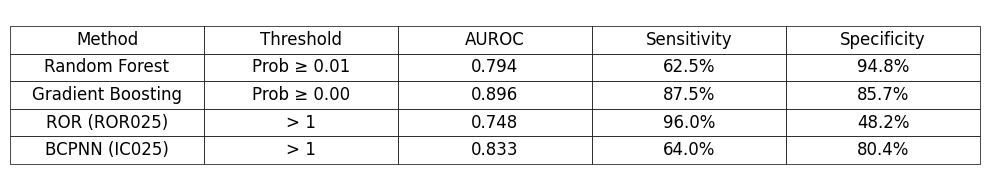

In [ ]:
def plot_performance_table(df):
    fig, ax = plt.subplots(figsize=(10, len(df) * 0.5))
    ax.axis('off')
    ax.axis('tight')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)

    for key, cell in table.get_celld().items():
        cell.set_edgecolor("black")
        cell.set_linewidth(0.5)

    fig.tight_layout()
    plt.show()

plot_performance_table(performance_df)
